In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100.0%
100.0%
100.0%
100.0%


In [11]:
image, label = train_dataset[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

Text(0.5, 1.0, 'Label: 5')

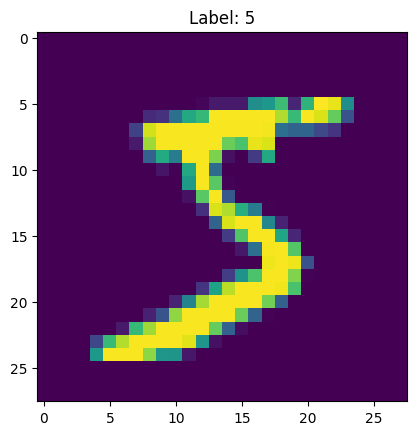

In [14]:
plt.imshow(image[0])
plt.title(f"Label: {label}")

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
class MySimpleCNN(nn.Module):
    def __init__(self):
        super(MySimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Conv 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)

        # Fully connected 1
        x = self.fc1(x)
        x = F.relu(x)
        
        # Fully connected 2
        x = self.fc2(x)

        return x

In [17]:
model = MySimpleCNN()
print(model)

MySimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [20]:
# Train
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs}: Train Loss {epoch_loss:.4f}")

Epoch 0/10: Train Loss 0.1909
Epoch 1/10: Train Loss 0.0541
Epoch 2/10: Train Loss 0.0366
Epoch 3/10: Train Loss 0.0285
Epoch 4/10: Train Loss 0.0215
Epoch 5/10: Train Loss 0.0177
Epoch 6/10: Train Loss 0.0136
Epoch 7/10: Train Loss 0.0116
Epoch 8/10: Train Loss 0.0093
Epoch 9/10: Train Loss 0.0096


In [21]:
# Test
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.05%


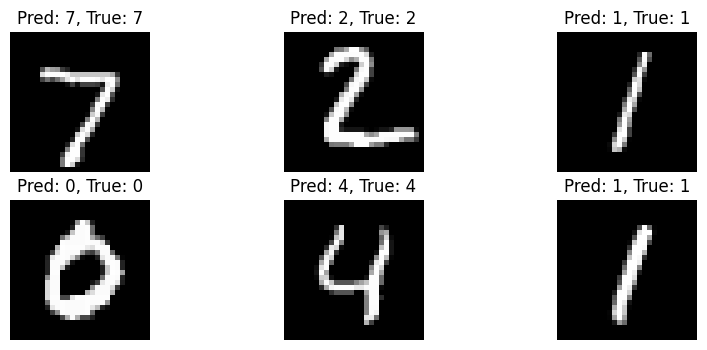

In [22]:
# Plot some predictions
images, labels = next(iter(test_loader))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predicted[i].item()}, True: {labels[i].item()}')
    plt.axis('off')
plt.show()